<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/seismic/AVO_Geobody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction of Gas-Bearing Sandstone Geobody from AVO Seismic Cubes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip -q install segyio
import segyio

     |████████████████████████████████| 84 kB 427 kB/s 


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
!git clone -q https://github.com/yohanesnuwara/computational-geophysics

import sys
sys.path.append('/content/computational-geophysics/seismic')
from seistool import *

In [4]:
from google.colab import drive
drive.mount('/content/drive') # yohannesnuwara@gmail.com

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/AVO/avo_a.zip
!unzip /content/drive/MyDrive/AVO/avo_b.zip

Archive:  /content/drive/MyDrive/AVO/avo_a.zip
  inflating: avo_a.sgy               
Archive:  /content/drive/MyDrive/AVO/avo_b.zip
  inflating: avo_b.sgy               


In [6]:
avoA = openSegy3D('/content/avo_a.sgy', iline=181, xline=185)

Successfully read 

Inline range from 2750 to 3450
Crossline range from 9250 to 9500
TWT from 0.0 to 1000.0
Sample rate: 4.0 ms
Survey rotation: 0.02 deg


In [7]:
avoB = openSegy3D('/content/avo_b.sgy', iline=181, xline=185)

Successfully read 

Inline range from 2750 to 3450
Crossline range from 9250 to 9500
TWT from 0.0 to 1000.0
Sample rate: 4.0 ms
Survey rotation: 0.02 deg


In [8]:
# Add TWT with time lag 1800 ms
avoA.twt = avoA.twt + 1800
avoB.twt = avoB.twt + 1800

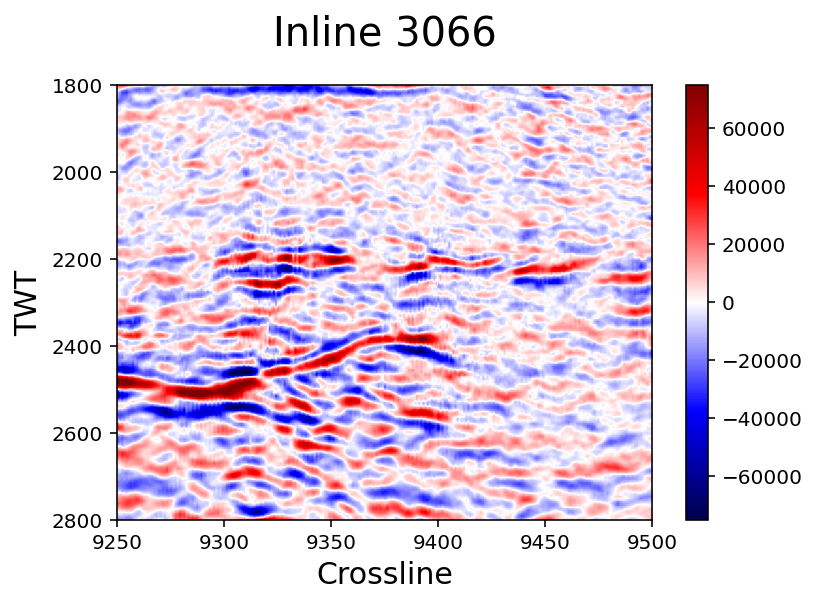

In [9]:
sliceCube(avoA, 'il', inline_loc=3066, display=True, 
          cmap='seismic', vmin=-7.5e4, vmax=7.5e4)

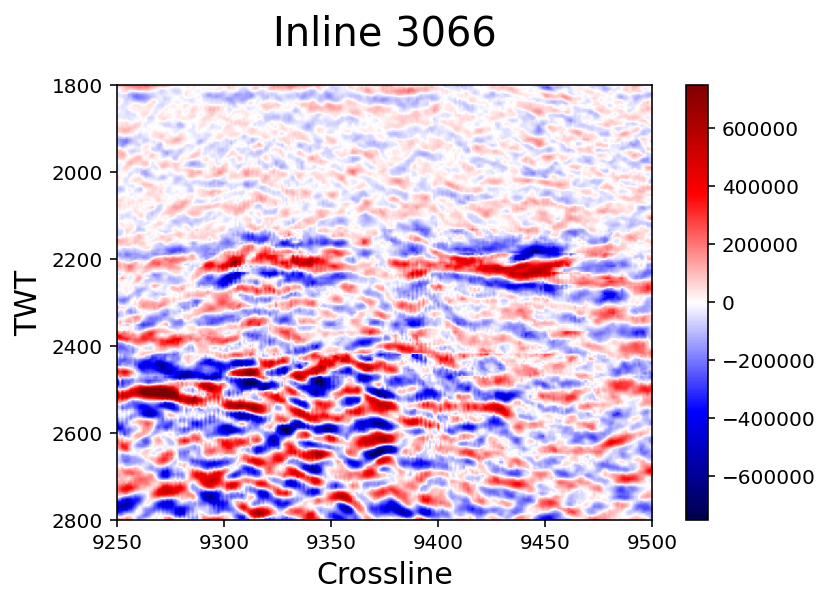

In [10]:
sliceCube(avoB, 'il', inline_loc=3066, display=True, 
          cmap='seismic', vmin=-.75e6, vmax=.75e6)

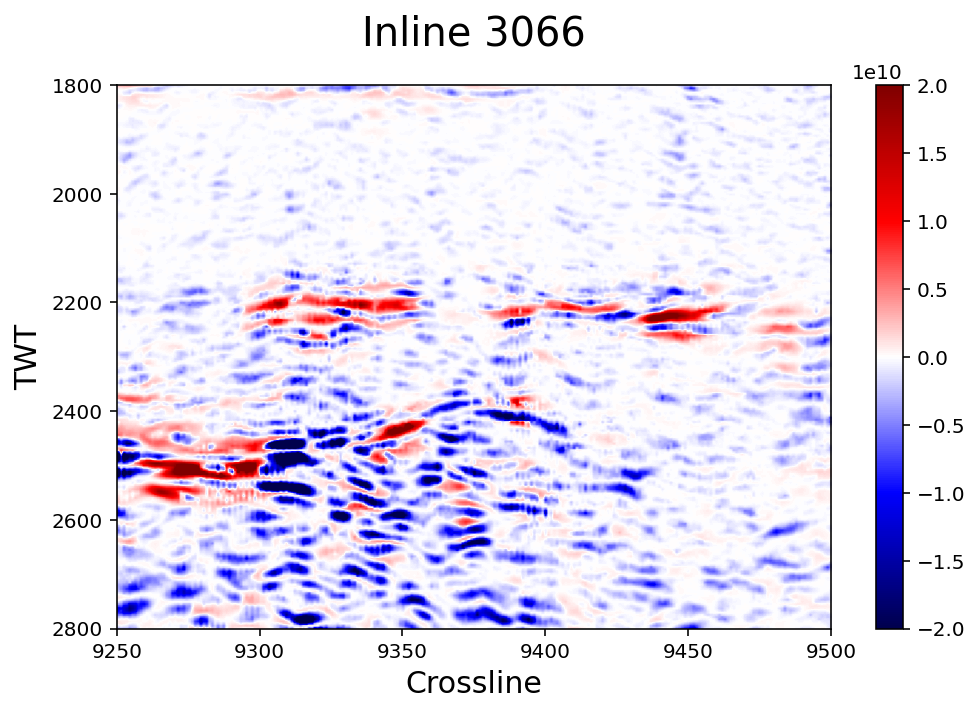

In [11]:
# Calculate A*B product
avoAB = avoA.data * avoB.data

avoAB = cube_constructor(avoAB, avoA.inlines, avoA.crosslines, avoA.twt)

sliceCube(avoAB, 'il', inline_loc=3066, display=True, 
          cmap='seismic', vmin=-2e10, vmax=2e10, figsize=(8,5))

Text(0.5, 1.0, 'AVO A*B (XL 9320)')

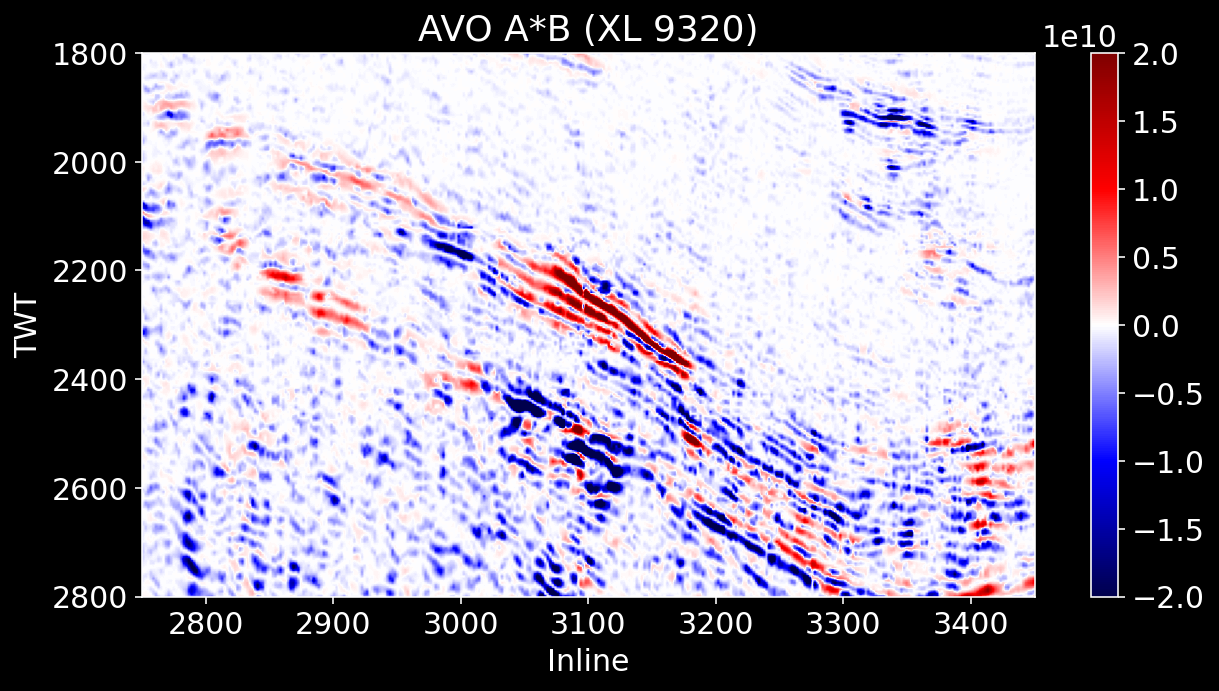

In [22]:
sliceCube(avoAB, 'xl', xline_loc=9320, display=True, 
          cmap='seismic', vmin=-2e10, vmax=2e10, figsize=(10,5))
plt.title('AVO A*B (XL 9320)')

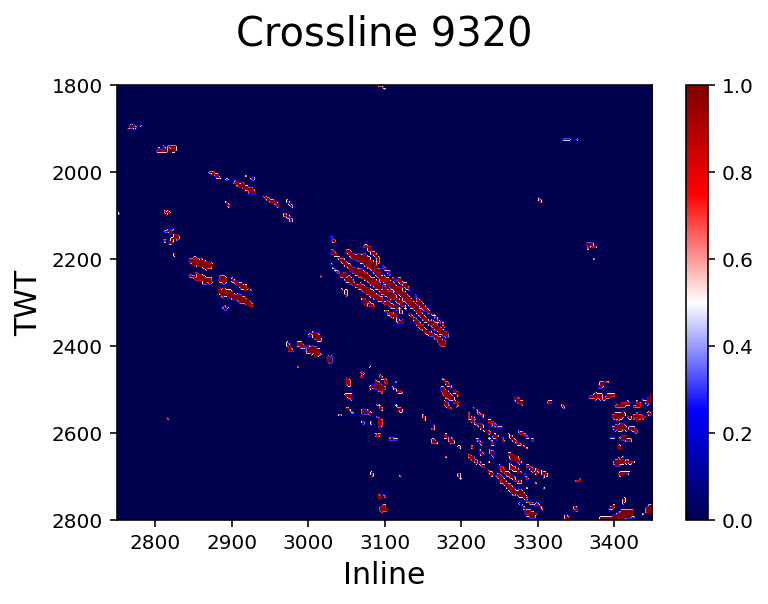

In [13]:
p = avoAB.data.copy()
p[(p>3e9)] = 1
p[p!=1] = 0

p = cube_constructor(p, avoA.inlines, avoA.crosslines, avoA.twt)

# sliceCube(p, 'il', inline_loc=3066, display=True, cmap='seismic')
sliceCube(p, 'xl', xline_loc=9320, display=True, cmap='seismic')

In [14]:
def extract_geobody(cube, value, range_x, range_y, range_z, 
                    figsize=(10,15), elev=90, azim=-90, title='Geobody'):
  """
  Extract geobody from an attribute cube

  INPUT:

  cube: Attribute cube object (3D array)
  value: Threshold value of attribute
  range_x: Min and max of x coordinate (Tuple)
  range_y: Min and max of y coordinate (Tuple)
  range_z: Min and max of z coordinate or TWT (Tuple)
  elev, azim: Viewing elevation and azimuth

  OUTPUT: 
  
  Plot of extracted geobodies
  """
  data = cube.copy()
  cube[cube>value] = 1
  cube[cube!=1] = 0
  # cube = np.swapaxes(cube, 1, 0)
  nx, ny, nz = cube.shape
  cube = np.array(cube, dtype=bool)

  x = np.linspace(range_x[0], range_x[1], nx+1)
  y = np.linspace(range_y[0], range_y[1], ny+1)
  z = np.linspace(range_z[0], range_z[1], nz+1)
  x, y, z = np.meshgrid(y, x, z) 

  colors = plt.cm.plasma(data)

  xw = np.full(50, 3066)
  yw = np.full(50, 9340)
  zw = np.linspace(t0, t1, 50)  

  def make_ax(grid=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    ax.set_title(title, pad=20)
    ax.set_xlabel("X", labelpad=20)
    ax.set_ylabel("Y", labelpad=20)
    ax.set_zlabel("TWT", labelpad=20)
    ax.grid(grid)
    ax.invert_zaxis()
    # ax.view_init(60,45)
    ax.view_init(elev, azim)
    return ax

  ax = make_ax(True)
  ax.voxels(x, y, z, cube, facecolor='lime', shade=False, edgecolors='k', linewidth=0.2)
  # ax.plot(yw, xw, zw, lw=10)
  plt.show()

In [15]:
# Index to cut
id_il0, id_il1 = 11*11, 11*19
id_xl0, id_xl1 = 11*4, 11*17 # 11*4, 11*13
id_t0, id_t1 = 75, 125 

# Cut locations
il0, il1 = avoA.inlines[id_il0], avoA.inlines[id_il1]
xl0, xl1 = avoA.crosslines[id_xl0], avoA.crosslines[id_xl1]
t0, t1 = avoA.twt[id_t0], avoA.twt[id_t1]

x = np.full(50, 3066)
y = np.full(50, 9380)
z = np.linspace(t0, t1, 50)

# Cut seismic data
data2 = avoAB.data.copy()
data2 = data2[id_il0:id_il1,id_xl0:id_xl1,id_t0:id_t1]

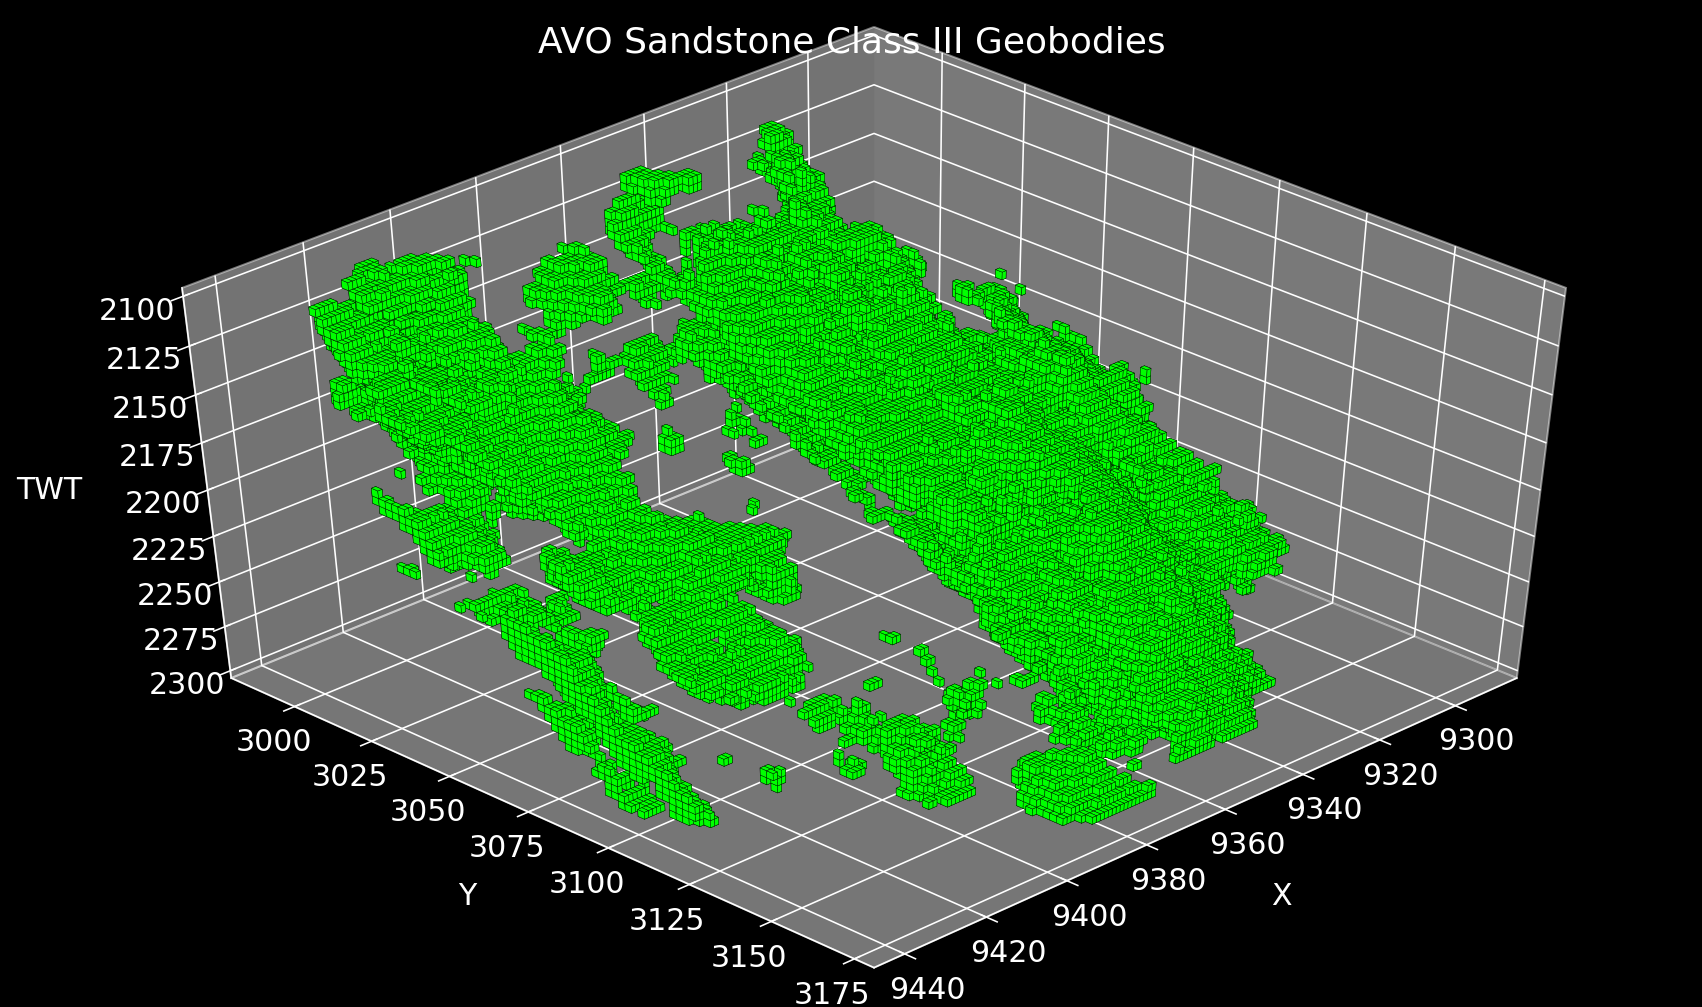

In [21]:
# AVO A*B threshold
thres = 3e9

# Visualize geobodies
plt.rcParams['font.size'] = 15
plt.style.use('dark_background')

extract_geobody(data2, thres, (il0,il1), (xl0,xl1), (t0,t1), 
                figsize=(15,9), azim=45, elev=45, 
                title='AVO Sandstone Class III Geobodies')

In [17]:
# def normalize(x):
#   xmax = np.amax(np.abs(x))
#   range = 1
#   return np.array([[[float(val) / xmax * range for val in row] for row in col] for col in x])

# # Normalize AVO cubes
# avoA_norm = normalize(avoA.data)
# avoB_norm = normalize(avoB.data)

# # Save results
# np.save('avo_a_norm.npy', avoA_norm)
# np.save('avo_b_norm.npy', avoB_norm)

In [18]:
# # Load normalized AVO A cube
# avoA_norm = np.load('/content/drive/MyDrive/AVO/avo_a_norm.npy')

# # Make cube object
# avoA_norm = cube_constructor(avoA_norm, avoA.inlines, avoA.crosslines, avoA.twt)